# Steam Data Exploration

## Import and Preprocess Data

In [1]:
# standard library imports
import itertools
import re

# third-party imports
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# customisations
pd.options.display.max_columns = 100
plt.style.use('default')
plt.rcdefaults()
# sns.set() # default seaborn style

In [2]:
pd.read_csv('../data/steam_clean.csv').head()

,AppID,Name,Release date,Estimated owners,Required age,Price,DLC count,Supported languages,Windows,Mac,Linux,Positive,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Categories,Genres,Tags,Developer,Publisher
0,20200,Galactic Bowling,2008-10-21,0 - 20000,0,19.99,0,['English'],True,False,False,6,11,30,0,0,0,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","['Indie', 'Casual', 'Sports']",Perpetual FX Creative,Perpetual FX Creative
1,655370,Train Bandit,2017-10-12,0 - 20000,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,53,5,12,0,0,0,"Single-player,Steam Achievements,Full controll...","Action,Indie","['Indie', 'Action', 'Pixel Graphics']",Rusty Moyher,Wild Rooster
2,1355720,Henosis™,2020-07-23,0 - 20000,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,3,0,0,0,0,0,"Single-player,Full controller support","Adventure,Casual,Indie","['2D Platformer', 'Atmospheric', 'Surreal']",Odd Critter Games,Odd Critter Games
3,1139950,Two Weeks in Painland,2020-02-03,0 - 20000,0,0.00,0,"['English', 'Spanish - Spain']",True,True,False,50,8,17,0,0,0,"Single-player,Steam Achievements","Adventure,Indie","['Indie', 'Adventure', 'Nudity']",Unusual Games,Unusual Games
4,1469160,Wartune Reborn,2021-02-26,50000 - 100000,0,0.00,0,['English'],True,False,False,87,49,0,0,0,0,"Single-player,Multi-player,MMO,PvP,Online PvP,...","Adventure,Casual,Free to Play,Massively Multip...","['Turn-Based Combat', 'Massively Multiplayer',...",7Road,7Road


In [3]:
def remove_non_english(df):
    # keep only rows marked as supporting English
    df = df[df['Supported languages'].str.contains('English')].copy()
    
    # keep rows which don't contain 3 or more non-ascii characters in succession
    df = df[~df['Name'].str.contains('[^\u0001-\u007F]{3,}')]
    
    # remove English column, now redundant
    df = df.drop('Supported languages', axis=1)
    
    return df

def iap(df):
    # Add a column for games with in-app purchases
    df['In-app purchases'] = df['Categories'].apply(lambda x: 1 if 'In-App Purchases' in x.split(',') else 0)
    
    return df


def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['Positive']
    neg = row['Negative']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-math.log10(total_reviews + 1))

    return score * 100


def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(',')]))))


def process_cat_gen_tag(df):
    """Process categories, genres and Tags columns."""
    # get all unique category names
    cat_cols = get_unique(df['Categories'])
    
    # only going to use these categories (can uncomment to use others)
    cat_cols = [
        # 'Local Multi-Player',
        # 'MMO',
        # 'Mods',
        'Multi-player',
        # 'Online Co-op',
        # 'Online Multi-Player',
        'Single-player'
    ]
    
    # create a new column for each category, with 1s indicating membership and 0s for non-members
    for col in sorted(cat_cols):
        col_name = re.sub(r'[\s\-\/]', '_', col.lower())
        col_name = re.sub(r'[()]', '', col_name)
        
        df[col_name] = df['Categories'].apply(lambda x: 1 if col in x.split(',') else 0)
        
    # repeat for genre column names (get_unique used to find unique genre names, 
    # not necessary but useful if keeping all of them)
    gen_cols = get_unique(df['Genres'])
    
    # only keeping 'main' genres similar to steam store
    gen_cols = [
        # 'Accounting',
        'Action',
        'Adventure',
        # 'Animation & Modeling',
        # 'Audio Production',
        'Casual',
        # 'Design & Illustration',
        # 'Documentary',
        # 'Early Access',
        # 'Education',
        # 'Free to Play',
        # 'Game Development',
        # 'Gore',
        'Indie',
        'Massively Multiplayer',
        # 'Nudity',
        # 'Photo Editing',
        'RPG',
        'Racing',
        # 'Sexual Content',
        'Simulation',
        # 'Software Training',
        'Sports',
        'Strategy'
        # 'Tutorial',
        # 'Utilities',
        # 'Video Production',
        # 'Violent',
        # 'Web Publishing'
    ]
    
    gen_col_names = []
    
    # create new columns for each genre with 1s for games of that genre
    for col in sorted(gen_cols):
        col_name = col.lower().replace('&', 'and').replace(' ', '_')
        gen_col_names.append(col_name)
        
        df[col_name] = df['Genres'].apply(lambda x: 1 if col in x.split(',') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['Genres'].str.contains(col), 1, 0)
    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = df[gen_col_names].sum(axis=1)
    df = df[gen_sums > 0].copy()
        
    # not using steamspy tags for now, as mostly overlap with genres
    # here's one way we could deal with them:
    # tag_cols = get_unique(df['Tags'])
    # df['top_tag'] = df['Tags'].apply(lambda x: x.split(';')[0])
    
    # remove redundant columns and return dataframe (keeping genres column for reference)
    df = df.drop(['Categories', 'Tags'], axis=1)
    
    return df


def pre_process():
    """Preprocess Steam dataset for exploratory analysis."""
    df = pd.read_csv('../data/steam_clean.csv')
    
    # add in-app purchases column
    df = iap(df)
        
    # keep lower bound of owners column, as integer
    df['Estimated owners'] = df['Estimated owners'].str.split('-').apply(lambda x: x[0]).astype(int)
    
    # calculate rating, as well as simple ratio for comparison
    df['Total Ratings'] = df['Positive'] + df['Negative']
    df = df[df['Total Ratings'] > 0].copy()
    df['Rating Ratio'] = df['Positive'] / df['Total Ratings']
    df['Rating'] = df.apply(calc_rating, axis=1)
    
    # convert release_date to datetime type and create separate column for release_year
    df['Release date'] = df['Release date'].astype('datetime64[ns]')
    df['Release Year'] = df['Release date'].apply(lambda x: x.year)
    
    # process genres, categories and steamspy_tag columns
    df = process_cat_gen_tag(df)
    
    return df

data = pre_process()

data.head()

,AppID,Name,Release date,Estimated owners,Required age,Price,DLC count,Supported languages,Windows,Mac,Linux,Positive,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Genres,Developer,Publisher,In-app purchases,Total Ratings,Rating Ratio,Rating,Release Year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,20200,Galactic Bowling,2008-10-21,0,0,19.99,0,['English'],True,False,False,6,11,30,0,0,0,"Casual,Indie,Sports",Perpetual FX Creative,Perpetual FX Creative,0,17,0.352941,27.901510,2008,1,1,0,0,1,1,0,0,0,0,1,0
1,655370,Train Bandit,2017-10-12,0,0,0.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,53,5,12,0,0,0,"Action,Indie",Rusty Moyher,Wild Rooster,0,58,0.913793,77.990614,2017,0,1,1,0,0,1,0,0,0,0,0,0
2,1355720,Henosis™,2020-07-23,0,0,5.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,3,0,0,0,0,0,"Adventure,Casual,Indie",Odd Critter Games,Odd Critter Games,0,3,1.000000,67.059371,2020,0,1,0,1,1,1,0,0,0,0,0,0
3,1139950,Two Weeks in Painland,2020-02-03,0,0,0.00,0,"['English', 'Spanish - Spain']",True,True,False,50,8,17,0,0,0,"Adventure,Indie",Unusual Games,Unusual Games,0,58,0.862069,73.576051,2020,0,1,0,1,0,1,0,0,0,0,0,0
4,1469160,Wartune Reborn,2021-02-26,50000,0,0.00,0,['English'],True,False,False,87,49,0,0,0,0,"Adventure,Casual,Free to Play,Massively Multip...",7Road,7Road,1,136,0.639706,56.697257,2021,1,1,0,1,1,0,1,1,0,0,0,1


## Data Overview

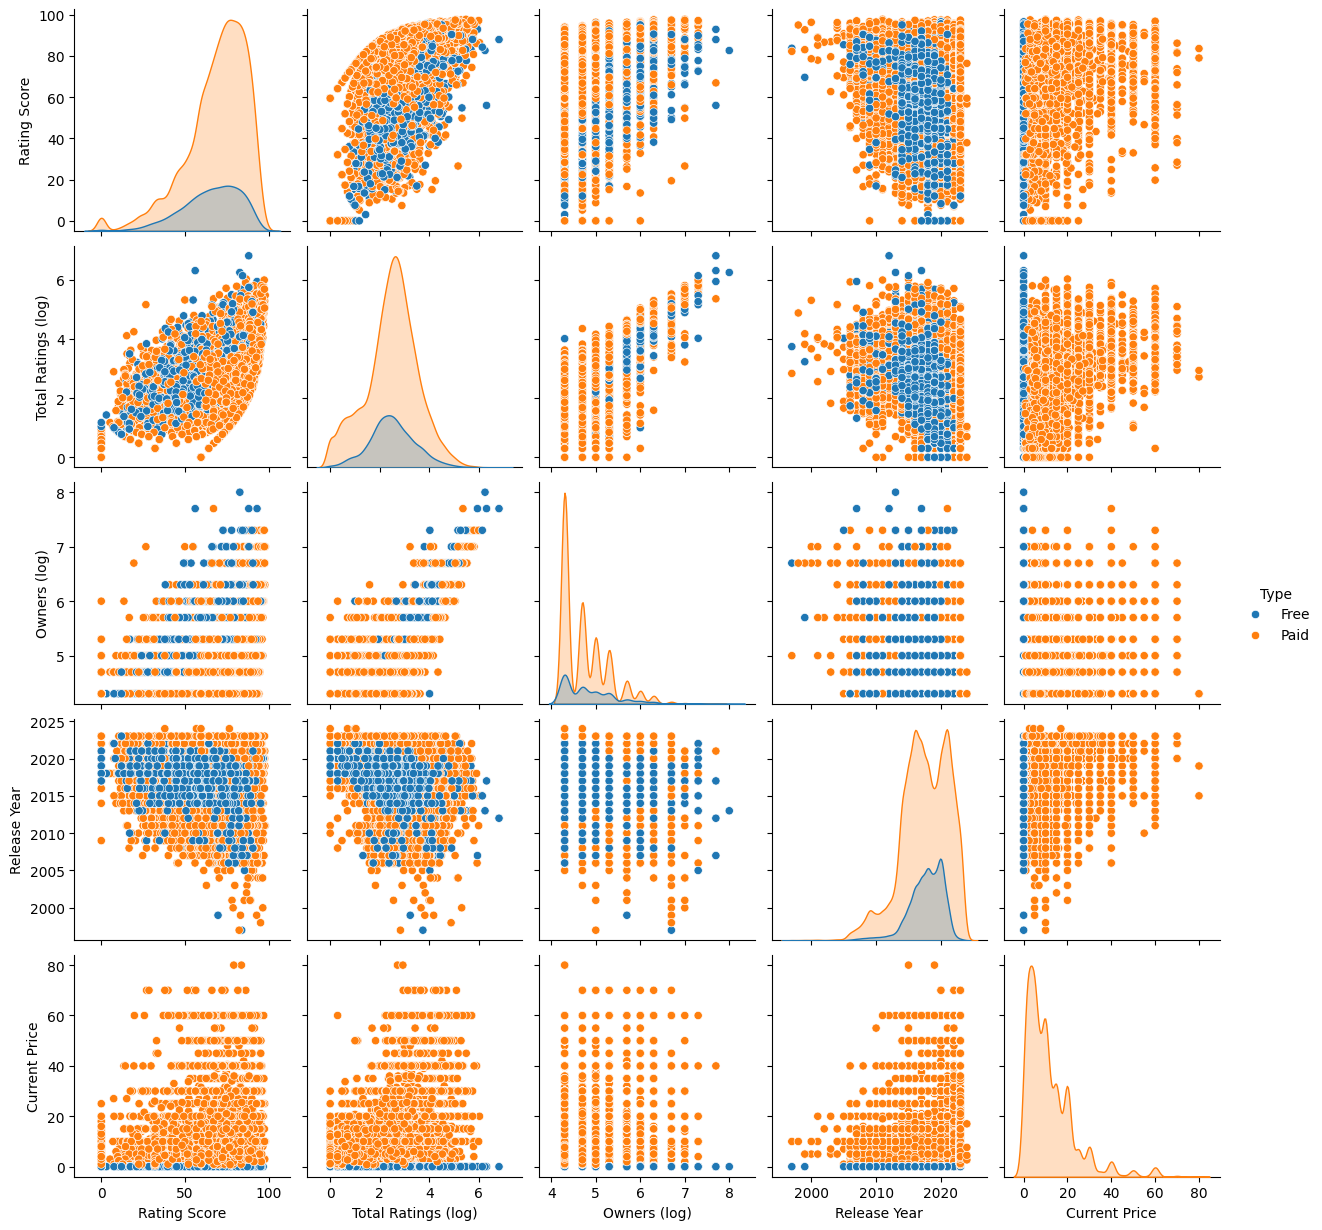

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Create a column to split free vs paid games
data['type'] = 'Free'
data.loc[data['Price'] > 0, 'type'] = 'Paid'

# ensure no 0s in columns we're applying log to
df = data[(data['Estimated owners'] > 0) & (data['Total Ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(df['Rating'],
                          np.log10(df['Total Ratings']),
                          np.log10(df['Estimated owners']),
                          df['Release Year'],
                          df['Price'],
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sns.pairplot(eda_df, hue='Type')
plt.show()

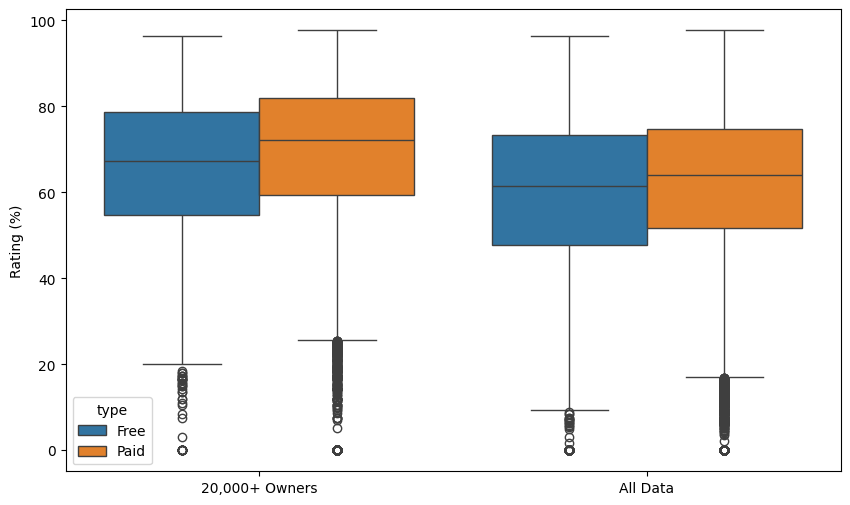

In [5]:
fig = plt.figure(figsize=(10,6))

dfa = data[data['Estimated owners'] >= 20000].copy()
dfa['subset'] = '20,000+ Owners'

dfb = data.copy()
dfb['subset'] = 'All Data'

ax = sns.boxplot(x='subset', y='Rating', hue='type', data=pd.concat([dfa, dfb]))

ax.set(xlabel='', ylabel='Rating (%)')
plt.show()

In [6]:
print(f'Games with fewer than 20,000 owners: {data[data["Estimated owners"] < 20000].shape[0]}\n',
      f'Games with more than 20,000 owners: {data[data["Estimated owners"] >= 20000].shape[0]}')

Games with fewer than 20,000 owners: 44287
 Games with more than 20,000 owners: 17823


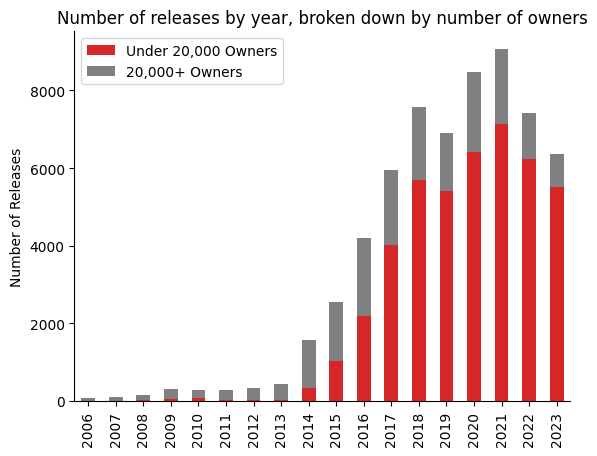

In [7]:
df = data.copy()

years = []
lt_20k = []
gt_20k = []

for year in sorted(df['Release Year'].unique()):
    if year < 2006 or year > 2023:
        continue
    
    # subset dataframe by year
    year_df = df[df['Release Year'] == year]
    
    # calculate total with less than 20,000 owners, and total with 20,000 or more
    total_lt_20k = year_df[year_df['Estimated owners'] < 20000].shape[0]
    total_gt_20k = year_df[year_df['Estimated owners'] >= 20000].shape[0]
    
    years.append(year)
    lt_20k.append(total_lt_20k)
    gt_20k.append(total_gt_20k)
    
owners_df = pd.DataFrame(zip(years, lt_20k, gt_20k), 
                         columns=['year', 'Under 20,000 Owners', '20,000+ Owners'])

ax = owners_df.plot(x='year', y=[1, 2], kind='bar', stacked=True, color=['tab:red', 'gray'])

ax.set_xlabel('')
ax.set_ylabel('Number of Releases')
ax.set_title('Number of releases by year, broken down by number of owners')
sns.despine()
plt.show()

## Release Year

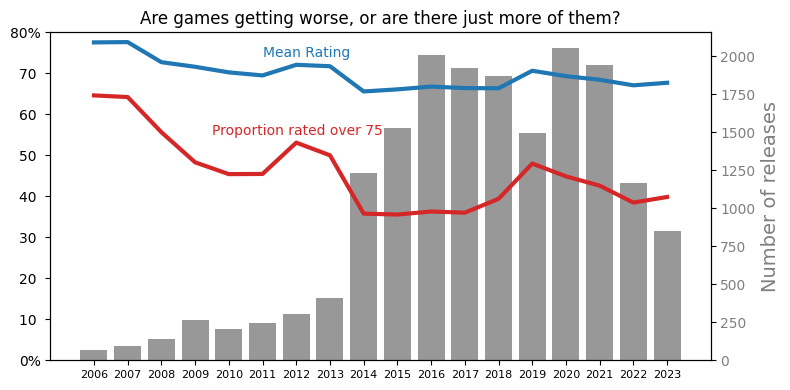

In [8]:
# Keeping games with only 20,000 owners or more
df = data[data['Estimated owners'] >= 20000].copy()

rating_threshold = 75

years = []
proportions = []
totals = []
avg_ratings = []
max_ratings = []

# calculate values for plotting
for year in sorted(df['Release Year'].unique()):
    if year < 2006 or year > 2023:
        continue
    
    year_data = df[df['Release Year'] == year]
    total = year_data.shape[0]
    n_high_rating = year_data[year_data['Rating'] >= rating_threshold].shape[0]
    avg_rating = year_data['Rating'].mean() / 100
    
    years.append(year)
    totals.append(total)
    proportions.append(n_high_rating/total)
    avg_ratings.append(avg_rating)
    
    # print(f'{year} | {n_high_rating/total:.2f}')
    
fig, ax1 = plt.subplots(figsize=(8,4))

# ensure lines drawn over bars
ax1.set_zorder(1)
ax1.patch.set_visible(False)

# plot trendlines
ax1.plot(avg_ratings, color='tab:blue', label='Average Rating', linewidth=3)
ax1.plot(proportions, color='tab:red', label=f'Proportion of games rated over {rating_threshold}', linewidth=3)

x_pos = np.arange(len(years))
ax1.set_xticks(x_pos)
ax1.set_xticklabels(years, fontsize=8)
ax1.set_yticks(np.arange(0, 0.9, 0.1))
ax1.set_yticklabels(['0%', '10 ', '20 ', '30 ', '40 ', '50 ', '60 ', '70 ', '80%'])

# instead of legend, place text directly over lines
ax1.text(5, 0.74, 'Mean Rating', color='tab:blue')
ax1.text(3.5, 0.55, 'Proportion rated over 75', color='tab:red')
# ax1.legend(loc='center', bbox_to_anchor=(0.5, 1.1))

# allow multiple axis on same plot
ax2 = ax1.twinx()

# plot number of releases by year
color = 'tab:gray'
ax2.bar(x_pos, totals, color=color, alpha=.8)

ax2.set_ylabel('Number of releases', color=color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Are games getting worse, or are there just more of them?')

fig.tight_layout()
plt.show()

In [9]:
import scipy.stats as stats
r, p_value = stats.pearsonr(totals, avg_ratings)

# using rating_ratio - pretty similar result
# stats.pearsonr(totals, df.groupby('Release Year').mean()['Rating']_ratio.loc[2006:2018].values)

print(f'Correlation coefficient (r): {r}\np-value: {p_value}')

Correlation coefficient (r): -0.7276721124880576
p-value: 0.0006196085193638523


## Top Games, Ratings and Genres


,Name,Developer,Publisher,Release Year,Genres,Average playtime forever,Estimated owners,Rating,Price
23910,Portal 2,Valve,Valve,2011,"Action,Adventure",874,10000000,97.688275,9.99
18441,People Playground,mestiez,Studio Minus,2019,"Action,Casual,Indie,Simulation",1973,2000000,97.455670,9.99
38825,Vampire Survivors,poncle,poncle,2021,"Action,Casual,Indie,RPG,Early Access",1309,2000000,97.412839,2.99
21590,Hades,Supergiant Games,Supergiant Games,2020,"Action,Indie,RPG",2075,5000000,97.361375,24.99
61201,Lethal Company,Zeekerss,Zeekerss,2023,"Action,Adventure,Indie,Early Access",472,5000000,97.302766,9.99
51254,Stardew Valley,ConcernedApe,ConcernedApe,2016,"Indie,RPG,Simulation",3753,10000000,97.193428,14.99
39367,Terraria,Re-Logic,Re-Logic,2011,"Action,Adventure,Indie,RPG",6729,20000000,97.097957,9.99
13962,Portal,Valve,Valve,2007,Action,484,10000000,96.947505,9.99
29992,RimWorld,Ludeon Studios,Ludeon Studios,2018,"Indie,Simulation,Strategy",10424,2000000,96.890968,34.99
14893,ULTRAKILL,Arsi Hakita Patala,New Blood Interactive,2020,"Action,Indie,Early Access",793,1000000,96.811219,19.99


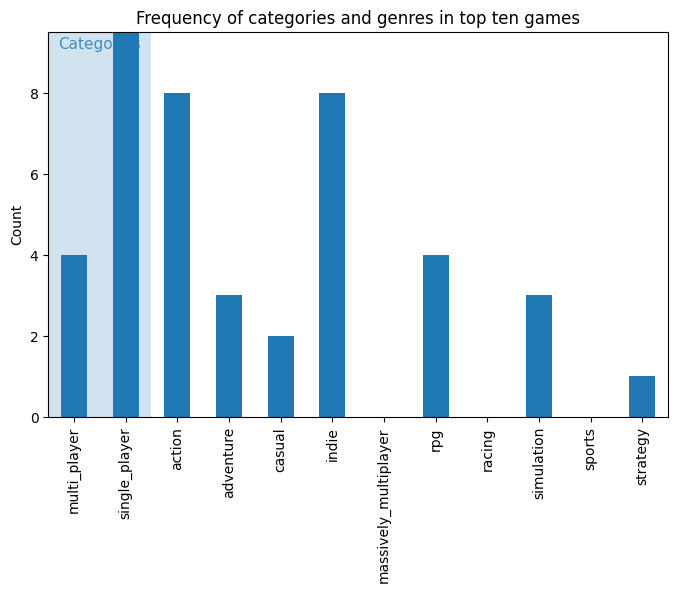

In [10]:
display_cols = ['Name', 'Developer', 'Publisher', 'Release Year', 'Genres', 'Average playtime forever', 'Estimated owners', 'Rating', 'Price']
top_ten = df.sort_values(by='Rating', ascending=False).head(10)

display(top_ten[display_cols])

# storing category and genre columns in a variable, as we'll be accessing them often
cat_gen_cols = df.columns[-13:-1]
ax = top_ten[cat_gen_cols].sum().plot.bar(figsize=(8,5))

ax.fill_between([-.5, 1.5], 10, alpha=.2)
ax.text(0.5, 9.1, 'Categories', fontsize=11, color='tab:blue', alpha=.8, horizontalalignment='center')

ax.set_ylim([0, 9.5])
ax.set_ylabel('Count')
ax.set_title('Frequency of categories and genres in top ten games')

plt.show()

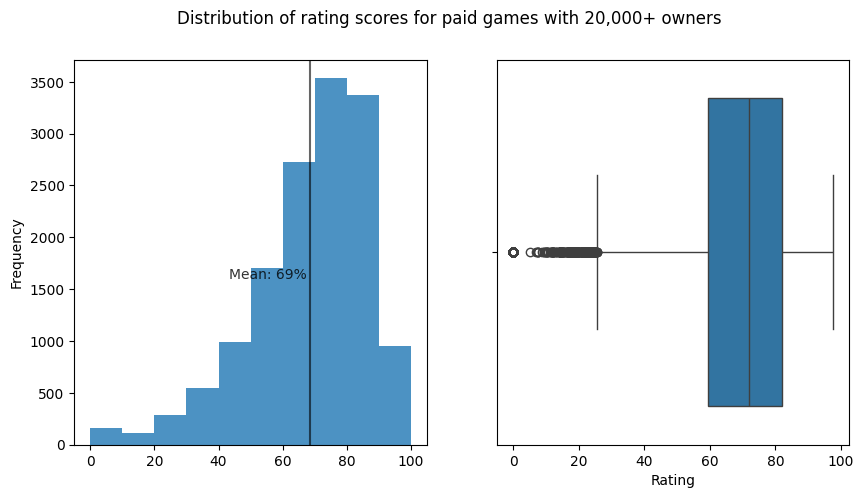

Mean rating: 68.55%


In [11]:
# paid with over 20,000 owners
df = data[(data['Estimated owners'] >= 20000) & (data['Price'] > 0)].copy()

fig, axarr = plt.subplots(1, 2, figsize=(10,5))

df['Rating'].plot.hist(range=(0, 100), bins=10, ax=axarr[0], alpha=.8)
# sns.distplot(df['Rating']g'], bins=range(0,100,10), ax=axarr[0])

# plot line for mean on histogram
mean = df['Rating'].mean()
axarr[0].axvline(mean, c='black', alpha=.6)
axarr[0].text(mean-1, 1600, f'Mean: {mean:.0f}%', c='black', ha='right', alpha=.8)


ax = sns.boxplot(x='Rating', data=df, orient='v', ax=axarr[1])
fig.suptitle('Distribution of rating scores for paid games with 20,000+ owners')
plt.show()

print(f"Mean rating: {df['Rating'].mean():.2f}%")

In [12]:
gen_cols = cat_gen_cols.drop(['multi_player', 'single_player'])

f = stats.f_oneway(*(df.loc[df[g] == 1, 'Rating'].values for g in gen_cols))
f

F_onewayResult(statistic=10.500391275538645, pvalue=2.1308917305132855e-16)

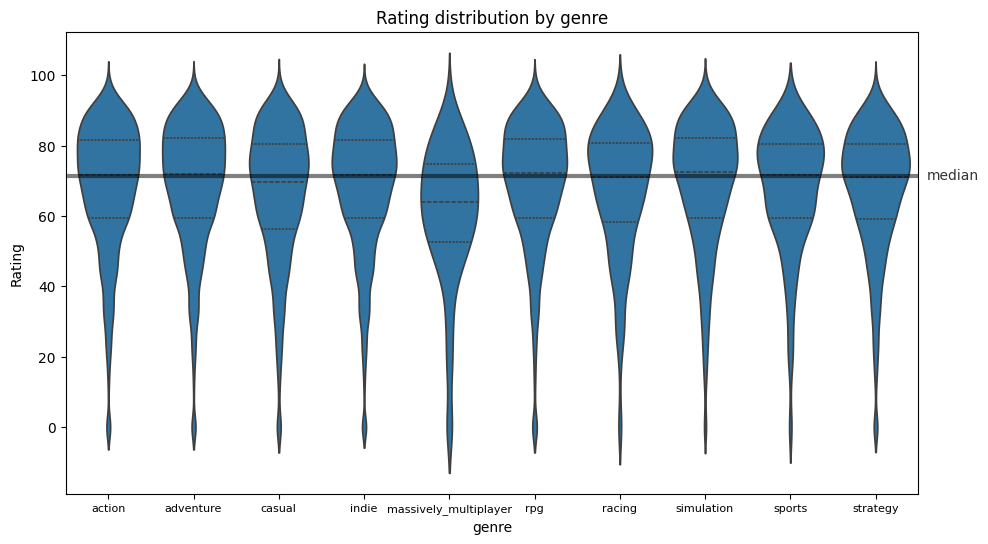

In [13]:
g_df = pd.DataFrame()

# create new dataframe with rating and genre, as games can belong to multiple genres
for col in gen_cols:
    ratings = pd.DataFrame(df.loc[df[col] == 1, 'Rating'].values, columns=['Rating'])
    ratings['genre'] = col
    g_df = pd.concat([g_df, ratings], axis=0)

fig, ax = plt.subplots(figsize=(11,6))
sns.violinplot(x='genre', y='Rating', data=g_df, inner='quartile', ax=ax)
ax.axhline(g_df['Rating'].median(), color='black', lw=3, alpha=.5)
ax.text(9.6, g_df['Rating'].median()-1, 'median', color='black', alpha=.8)

ax.tick_params(axis='x', labelsize=8)
ax.set_title("Rating distribution by genre")
plt.show()

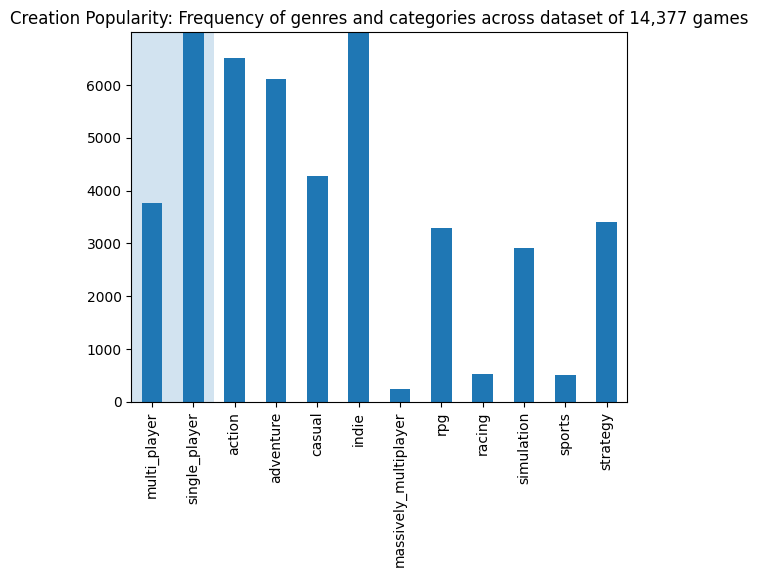

In [14]:
ax = df[cat_gen_cols].sum().plot.bar()

ax.fill_between([-.5, 1.5], 7000, alpha=.2)
ax.set_ylim([0, 6999])
ax.set_title(f'Creation Popularity: Frequency of genres and categories across dataset of {df.shape[0]:,} games')

plt.show()

<Figure size 1000x500 with 0 Axes>

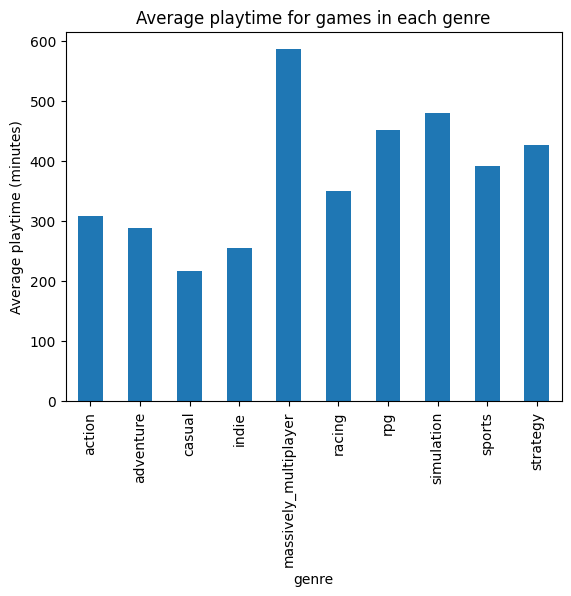

In [15]:
# plot average playtime for games in each genre
playtime_df = pd.DataFrame()

for col in gen_cols:
    playtimes = pd.DataFrame(df.loc[df[col] == 1, 'Median playtime forever'].values, columns=['Playtime'])
    playtimes['genre'] = col
    playtime_df = pd.concat([playtime_df, playtimes], axis=0)
average_playtime = playtime_df.groupby('genre').mean()

plt.figure(figsize=(10,5))
ax = average_playtime.plot.bar(legend=False)
ax.set_ylabel('Average playtime (minutes)')
ax.set_title('Average playtime for games in each genre')
plt.show()

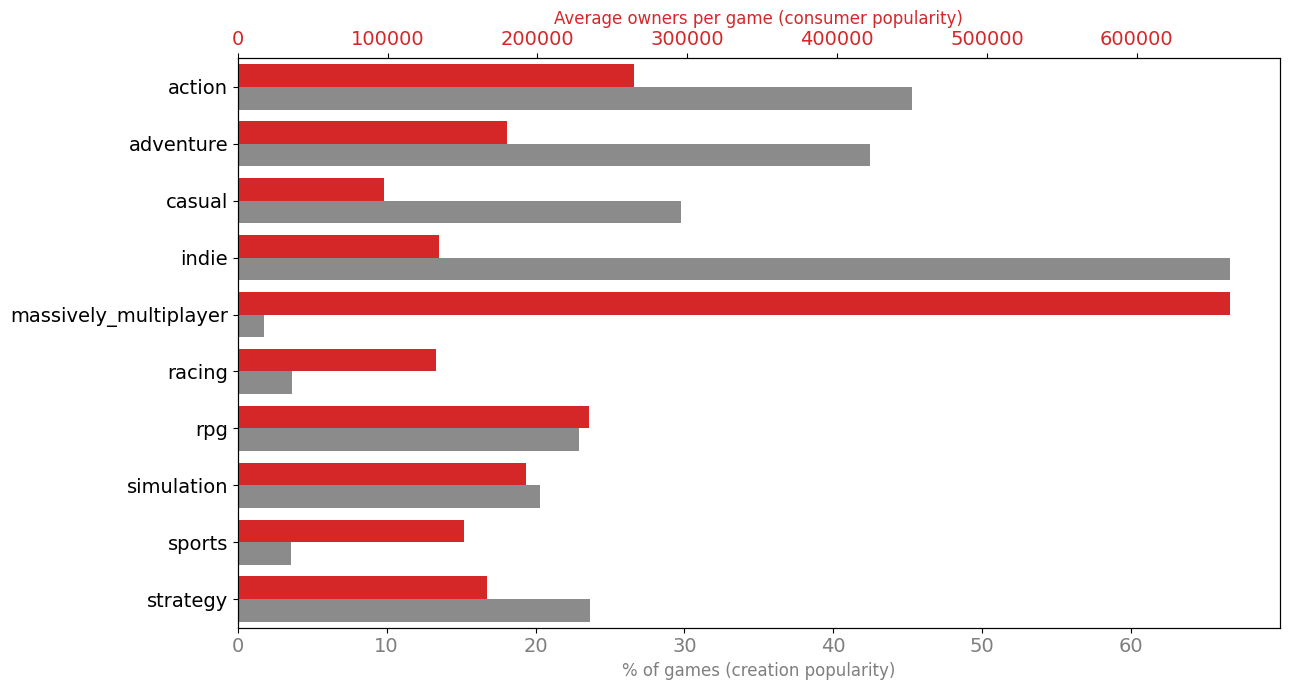

In [16]:
def plot_owners_comparison(df):
    # percentage of games in each genre
    total_owners_per_genre = df[gen_cols].multiply(df['Estimated owners'], axis='index').sum()
    average_owners_per_genre = total_owners_per_genre / df[gen_cols].sum()

    fig, ax1 = plt.subplots(figsize=(13,7))

    color = 'tab:gray'
    (df[gen_cols].mean() * 100).sort_index(ascending=False).plot.barh(ax=ax1, color=color, alpha=.9, position=1, fontsize=14, width=0.4)
    # ax1.set_ylabel('genre')

    ax1.set_xlabel('% of games (creation popularity)', color=color, size=12)
    ax1.tick_params(axis='x', labelcolor=color)
    ax1.tick_params(axis='y', left='off', top='off')
    # ax1.axes.get_yaxis().set_visible(False)

    ax2 = ax1.twiny()

    color = 'tab:red'
    average_owners_per_genre.sort_index(ascending=False).plot.barh(ax=ax2, color=color, alpha=1, position=0, fontsize=14, width=0.4)
    ax2.set_xlabel('Average owners per game (consumer popularity)', color=color, size=12)
    ax2.tick_params(axis='x', labelcolor=color)
    ax2.axes.get_yaxis().set_visible(False)
    ax2.set_ylim([-.5, 9.5])

    plt.tight_layout()
    plt.show()
    
plot_owners_comparison(df)

In [17]:
df[df['Estimated owners'] > 10000000]

,AppID,Name,Release date,Estimated owners,Required age,Price,DLC count,Supported languages,Windows,Mac,Linux,Positive,Negative,Achievements,Recommendations,Average playtime forever,Median playtime forever,Genres,Developer,Publisher,In-app purchases,Total Ratings,Rating Ratio,Rating,Release Year,multi_player,single_player,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,type
1097,4000,Garry's Mod,2006-11-29,20000000,0,9.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,822326,29004,29,725462,10891,1239,"Indie,Simulation",Facepunch Studios,Valve,0,851330,0.965931,95.800998,2006,1,1,0,0,0,1,0,0,0,1,0,0,Paid
6004,1063730,New World,2021-09-28,50000000,0,39.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,False,154914,73900,133,196597,7432,3093,"Action,Adventure,Massively Multiplayer,RPG",Amazon Games,Amazon Games,1,228814,0.677030,66.878484,2021,1,0,1,1,0,0,1,1,0,0,0,0,Paid
7043,359550,Tom Clancy's Rainbow Six® Siege,2015-12-01,20000000,18,19.99,11,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,False,929372,138530,0,899477,13837,3100,Action,Ubisoft Montreal,Ubisoft,1,1067902,0.870278,86.361245,2015,1,1,1,0,0,0,0,0,0,0,0,0,Paid
27798,1245620,ELDEN RING,2022-02-24,20000000,16,59.99,0,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,False,460812,51238,42,391693,5293,4467,"Action,RPG",FromSoftware Inc.,"FromSoftware Inc.,Bandai Namco Entertainment",0,512050,0.899936,89.133539,2022,1,1,1,0,0,0,0,1,0,0,0,0,Paid
28341,892970,Valheim,2021-02-02,20000000,0,19.99,1,"['English', 'French', 'German', 'Spanish - Spa...",True,False,True,337177,16241,0,305370,2778,1325,"Action,Adventure,Indie,RPG,Early Access",Iron Gate AB,Coffee Stain Publishing,0,353418,0.954046,94.385208,2021,1,1,1,1,0,1,0,1,0,0,0,0,Paid
28761,945360,Among Us,2018-11-16,20000000,0,3.99,0,"['English', 'Portuguese - Brazil', 'Spanish - ...",True,False,False,577656,51069,24,553709,1360,669,Casual,Innersloth,Innersloth,0,628725,0.918774,91.051965,2018,1,0,0,0,1,0,0,0,0,0,0,0,Paid
29720,252490,Rust,2018-02-08,20000000,18,39.99,4,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,False,703687,108223,90,655687,16623,3035,"Action,Adventure,Indie,Massively Multiplayer,RPG",Facepunch Studios,Facepunch Studios,1,811910,0.866706,85.949622,2018,1,0,1,1,0,1,1,1,0,0,0,0,Paid
33367,218620,PAYDAY 2,2013-08-13,20000000,18,9.99,75,"['English', 'German', 'French', 'Italian', 'Sp...",True,False,True,520826,62574,1287,375054,6177,686,"Action,RPG",OVERKILL - a Starbreeze Studio.,Starbreeze Publishing AB,1,583400,0.892743,88.453965,2013,1,1,1,0,0,0,0,1,0,0,0,0,Paid
33547,550,Left 4 Dead 2,2009-11-16,20000000,0,9.99,0,"['Danish', 'Dutch', 'English', 'Finnish', 'Fre...",True,True,True,619457,16204,101,457367,2166,529,Action,Valve,Valve,0,635661,0.974508,96.578252,2009,1,1,1,0,0,0,0,0,0,0,0,0,Paid
39367,105600,Terraria,2011-05-16,20000000,0,9.99,2,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,964983,21044,104,783469,6729,1810,"Action,Adventure,Indie,RPG",Re-Logic,Re-Logic,0,986027,0.978658,97.097957,2011,1,1,1,1,0,1,0,1,0,0,0,0,Paid


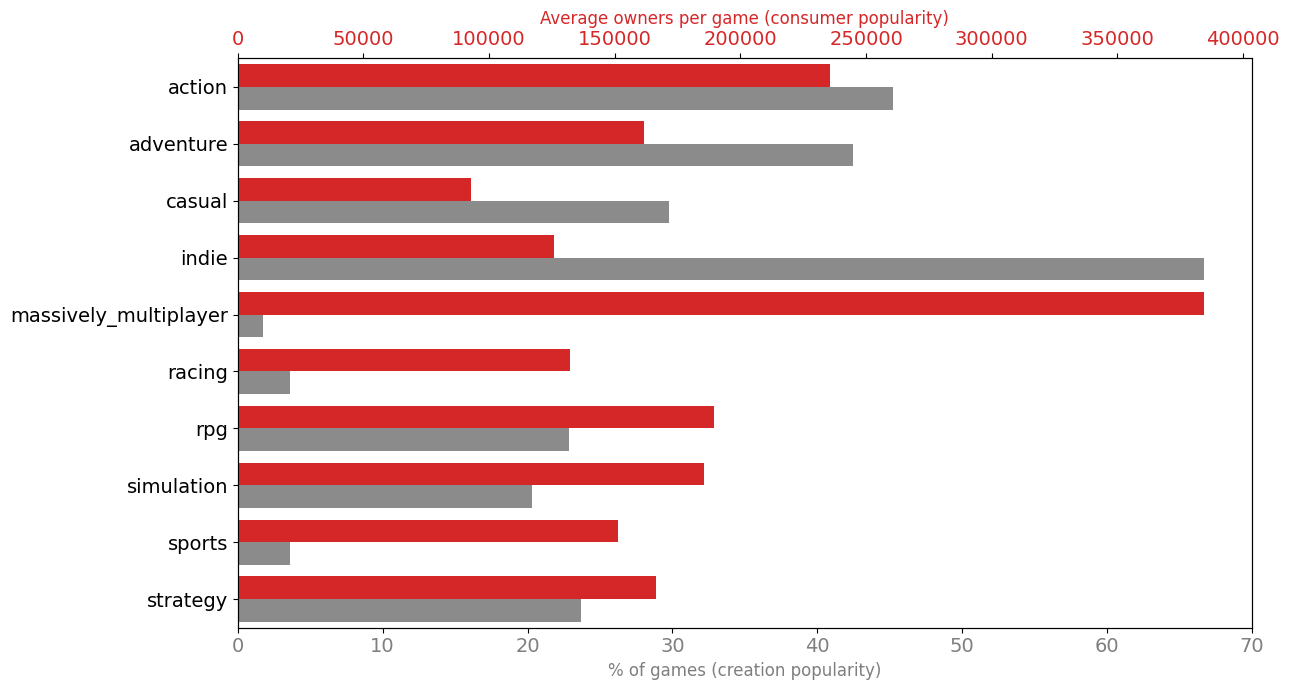

In [18]:
plot_owners_comparison(df[df['Estimated owners'] <= 10000000])

## Owners, Pricing and Ratings

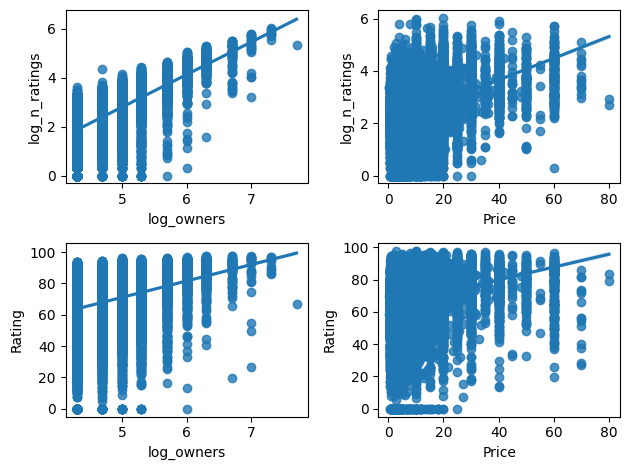

In [19]:
log_df = pd.DataFrame(zip(np.log10(df['Estimated owners']), np.log10(df['Total Ratings']), df['Rating'], df['Price']),
                      columns=['log_owners', 'log_n_ratings', 'Rating', 'Price'])

fig, axarr = plt.subplots(2, 2)

sns.regplot(x='log_owners', y='log_n_ratings', data=log_df, ax=axarr[0][0])
sns.regplot(x='log_owners', y='Rating', data=log_df, ax=axarr[1][0])
sns.regplot(x='Price', y='log_n_ratings', data=log_df, ax=axarr[0][1])
sns.regplot(x='Price', y='Rating', data=log_df, ax=axarr[1][1])

plt.tight_layout()
plt.show()

In [20]:
df[df['Estimated owners'] == df['Estimated owners'].max()][display_cols + ['Positive', 'Negative']]

,Name,Developer,Publisher,Release Year,Genres,Average playtime forever,Estimated owners,Rating,Price,Positive,Negative
6004,New World,Amazon Games,Amazon Games,2021,"Action,Adventure,Massively Multiplayer,RPG",7432,50000000,66.878484,39.99,154914,73900


Text(0.5, 1.0, 'Expected number of ratings per sale')

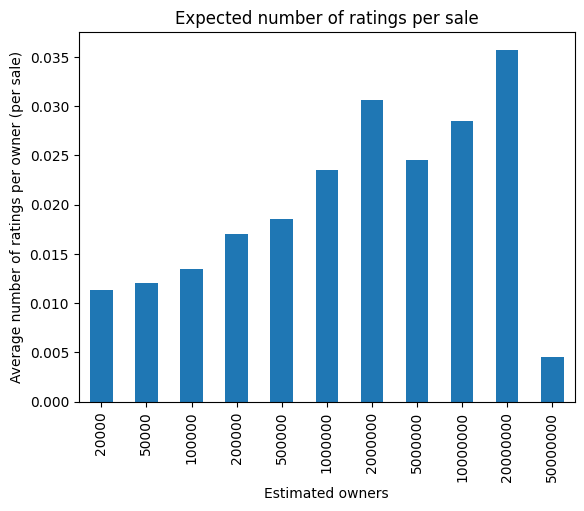

In [21]:
grp = df.groupby('Estimated owners')

ax = (grp['Total Ratings'].mean() / sorted(df['Estimated owners'].unique())).plot.bar()
ax.set_ylabel('Average number of ratings per owner (per sale)')
ax.set_title('Expected number of ratings per sale')

## Pricing

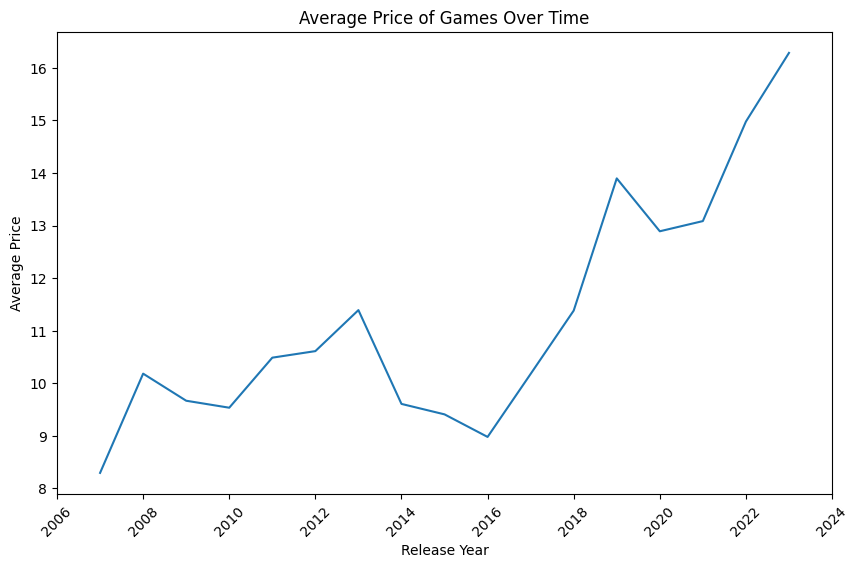

In [22]:
df['Release Year'] = df['Release date'].dt.year
avg_price_over_time = df.groupby('Release Year')['Price'].mean().reset_index()
plt.subplots(figsize = (10,6))
plt.plot(avg_price_over_time['Release Year'][10:-1], avg_price_over_time['Price'][10:-1])
plt.xlabel('Release Year')
plt.ylabel('Average Price')
plt.xticks(ticks=plt.xticks()[0], rotation=45, labels=plt.xticks()[0].astype(int))
plt.title('Average Price of Games Over Time')
plt.show()

In [23]:
# Filter the dataframe to only include rows where the 'Release Year' is between 2007 and 2023
filtered_df = df[(df['Release Year'] >= 2007) & (df['Release Year'] <= 2023)]

# Calculate the correlation between price and release date
r, p_value = stats.pearsonr(filtered_df['Price'], filtered_df['Release Year'])
print(f'Correlation coefficient (r): {r}\np-value: {p_value}')

Correlation coefficient (r): 0.16435615955300586
p-value: 4.658705454132888e-87


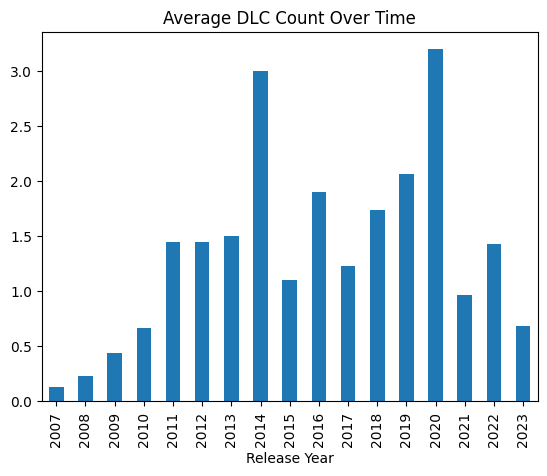

In [24]:
# Plot DLC over time
filtered_df.groupby('Release Year')['DLC count'].mean().plot(kind='bar')
plt.title('Average DLC Count Over Time')
plt.show()

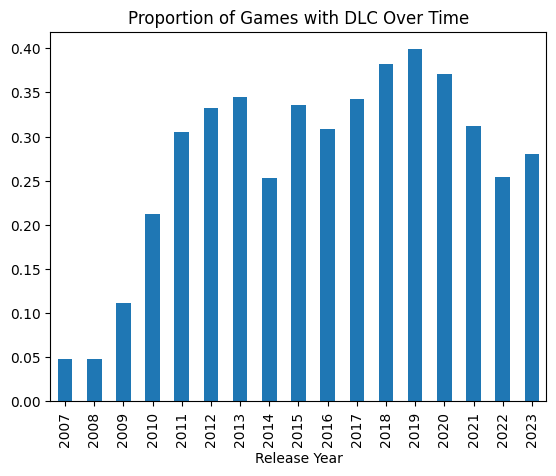

In [25]:
# Calculate the proportion of games with DLC
total_games_per_year = filtered_df['Release Year'].value_counts().sort_index()
dlc_games_per_year = filtered_df[filtered_df['DLC count'] > 0]['Release Year'].value_counts().sort_index()
dlc_proportion = (dlc_games_per_year / total_games_per_year).fillna(0)

# Plot proportion of games with DLC over time
dlc_proportion.plot(kind='bar')
plt.title('Proportion of Games with DLC Over Time')
plt.show()

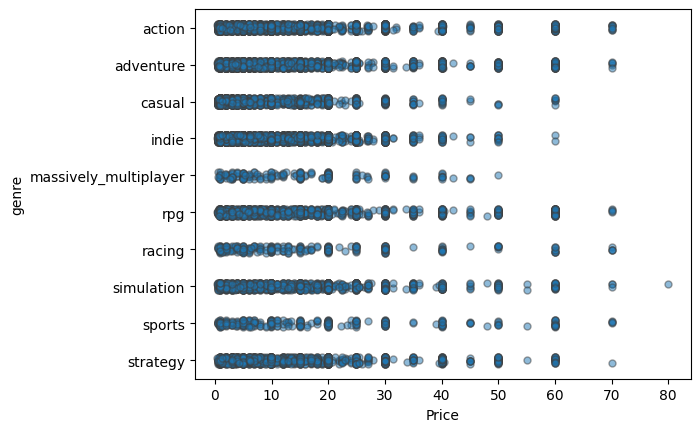

In [26]:
g_df = pd.DataFrame()

for col in gen_cols:
    temp_df = df[df[col] == 1].copy()
    temp_df['genre'] = col
    g_df = pd.concat([g_df, temp_df], axis=0)


recent_df = g_df[g_df['Release Year'] >= 2018].copy()
ax = sns.stripplot(x='Price', y='genre', data=recent_df, jitter=True, alpha=.5, linewidth=1);

# Languages and Platforms

7        [English, Polish, French, Italian, German, Spa...
8               [English, French, German, Polish, Russian]
11                                               [English]
13       [English, French, German, Italian, Japanese, S...
15       [English, French, German, Spanish - Spain, Rus...
                               ...                        
62485                                            [English]
62491                                            [English]
62495    [English, French, Italian, German, Japanese, K...
62520                                            [English]
62548                                   [English, Russian]
Name: Supported languages, Length: 14377, dtype: object
English


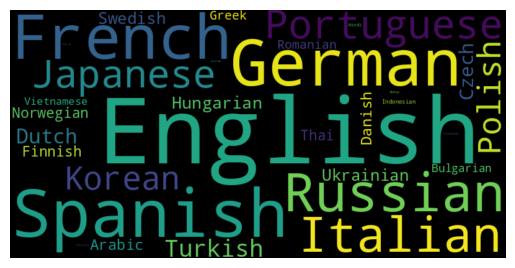

In [27]:
import ast
from wordcloud import WordCloud
df['Supported languages'] = df['Supported languages'].apply(ast.literal_eval)
print(df['Supported languages'])
all_languages = [lang for sublist in df['Supported languages'] for lang in sublist]
print(all_languages[0])
all_languages = [x.split(' - ')[0] for x in all_languages]

all_languages = [x for x in all_languages if x.isalpha()]

word_counts = {}
for word in all_languages:
    word_counts[word] = word_counts.get(word, 0) + 1

wordcloud = WordCloud(width=800, height=400, background_color='black')
wordcloud.generate_from_frequencies(word_counts)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

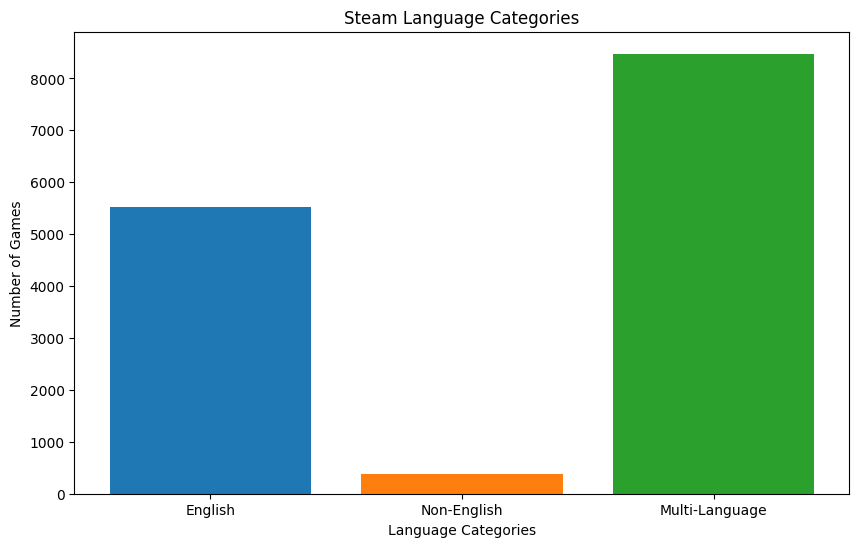

In [28]:
# Categorize languages
categories = {'English': 0, 'Non-English': 0, 'Multi-Language': 0}

# Helper function to determine category
def categorize(language):
    if language == ['English']:
        return 'English'
    elif len(language) > 1 and 'English' in language:
        return 'Multi-Language'
    else:
        return 'Non-English'

# Count languages in each category
for language in df['Supported languages']:
    category = categorize(language)
    categories[category] += 1

# Data for plotting
categories_names = list(categories.keys())
categories_counts = list(categories.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(categories_names, categories_counts, color=tuple(['tab:blue', 'tab:orange', 'tab:green']))
plt.xlabel('Language Categories')
plt.ylabel('Number of Games')
plt.title('Steam Language Categories')
plt.show()


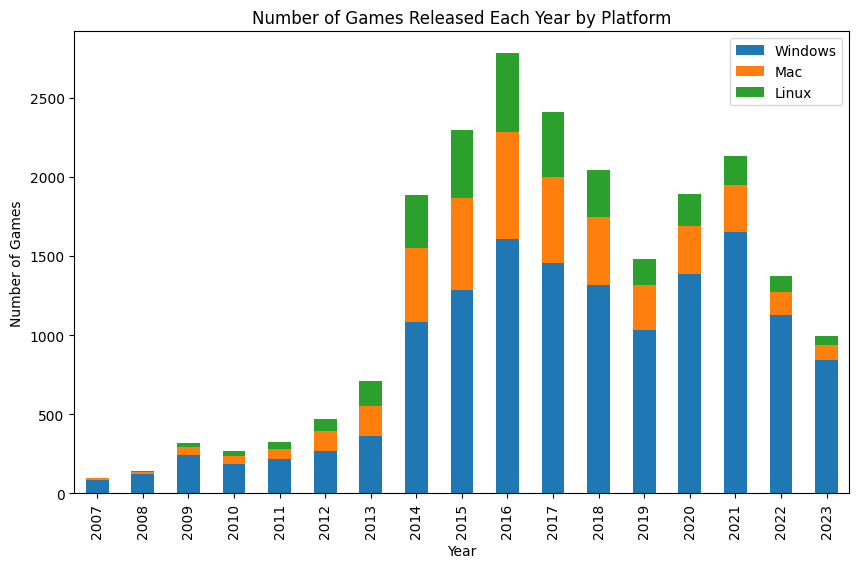

In [29]:
# Plot the number of games released each year for each platform
fig, ax = plt.subplots(figsize=(10, 6))

# Create a dataframe with the number of games released each year for each platform
platforms = ['Windows', 'Mac', 'Linux']
platform_counts = pd.DataFrame()

for platform in platforms:
    platform_data = filtered_df[filtered_df[platform] == 1]
    platform_counts[platform] = platform_data.groupby('Release Year').size()
    
platform_counts.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Games')
ax.set_title('Number of Games Released Each Year by Platform')
plt.show()

## Developers and Publishers

In [30]:
pv = df.pivot_table(index='Developer', 
               values=['AppID', 'Rating'], 
               aggfunc={'AppID':'count', 'Rating':np.mean})

pv = pv.rename({'AppID':'num_releases'}, axis=1).sort_values(by='Rating', ascending=False)

pv.head()

,num_releases,Rating
Developer,,
mestiez,1,97.455670
poncle,1,97.412839
ConcernedApe,1,97.193428
Re-Logic,1,97.097957
Ludeon Studios,1,96.890968


In [31]:
def get_scores(df):
    # extracting values
    num_releases = df.num_releases**(1/2)
    log_owners = np.log10(df.sum_owners)
    mean_rating = df.mean_rating
    log_ratings = np.log10(df['Total Ratings'])
    
    # calculating z scores
    z_num_releases = stats.zscore(num_releases)
    z_log_owners = stats.zscore(log_owners)
    z_mean_rating = stats.zscore(mean_rating)
    z_log_ratings = stats.zscore(log_ratings)

    # calculate score (per row)
    # half owners and number of ratings, because allude to the same thing
    # give smaller weight to number of releases
    # rating most important, give highest weighting
    scores = (.1*z_num_releases + .5*.2*z_log_owners + .5*z_mean_rating + .5*.25*z_log_ratings) / 3
        
    return scores

pv_df = df.copy()
pv_df['num_releases'] = 1

pv_df['is_indie'] = pv_df['Genres'].apply(lambda x: 1 if 'Indie' in x else 0)

pv = pv_df.pivot_table(index='Developer',
                       values=['num_releases', 'Estimated owners', 'Rating', 'Total Ratings', 'Price', 'is_indie'],
                       aggfunc={'num_releases': np.sum,
                                'Estimated owners': np.sum, 
                                'Rating': np.mean,
                                'Total Ratings': np.sum,
                                'Price': np.mean,
                                'is_indie': np.max}
                      ).rename({'Estimated owners': 'sum_owners', 
                                'Price': 'mean_price',
                                'Rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)
pv = pv.sort_values(by='score', ascending=False)
pv.head(10)

,sum_owners,mean_price,mean_rating,Total Ratings,is_indie,num_releases,score
Developer,,,,,,,
Valve,143000000,10.990000,89.191334,1878572,0,21,0.795684
"KOEI TECMO GAMES CO., LTD.",8840000,42.870597,68.151353,190061,0,67,0.781680
"CAPCOM Co., Ltd.",29510000,30.698333,83.830107,906617,0,24,0.720900
Square Enix,9830000,26.959697,74.751544,236002,0,33,0.655774
Quiet River,2280000,1.262727,87.099501,69099,1,22,0.631153
id Software,11600000,12.516316,80.977465,408394,0,19,0.616418
Ubisoft Montreal,31050000,16.731000,74.513411,1276755,0,20,0.607853
"PopCap Games, Inc.",3810000,4.990000,83.269244,106320,0,21,0.606708
Klei Entertainment,14600000,15.690000,88.706522,560798,1,10,0.603830


In [32]:
# Categorize developers into new or veteran developers
pv_df['is_veteran'] = pv_df.groupby('Developer')['num_releases'].transform('count').ge(2).astype(int)

# Calculate average total ratings for each category of developers
avg_ratings = pv_df.groupby(['is_indie', 'is_veteran'])['Total Ratings'].mean().reset_index()
avg_ratings.head()

,is_indie,is_veteran,Total Ratings
0,0,0,5569.463235
1,0,1,8404.075347
2,1,0,2560.052603
3,1,1,3308.310811


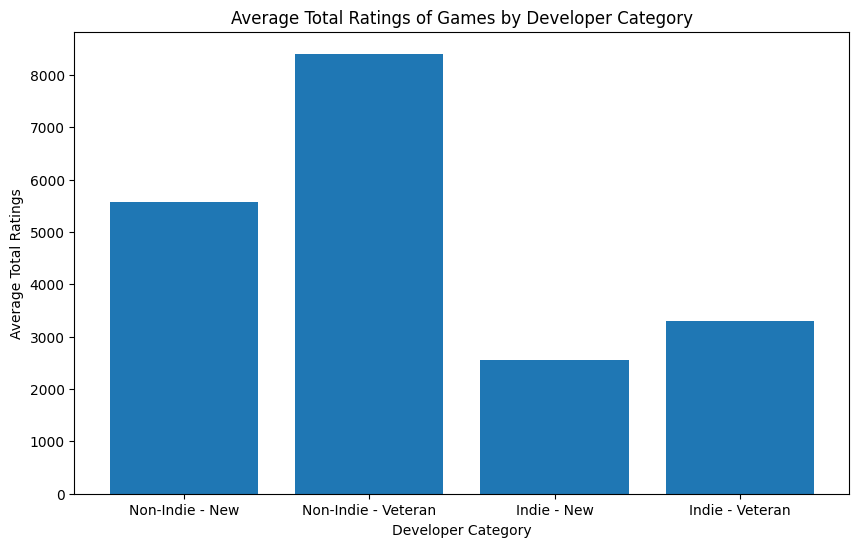

In [33]:

# Create a bar graph
plt.figure(figsize=(10,6))
plt.bar(avg_ratings['is_indie'].astype(str) + ' - ' + avg_ratings['is_veteran'].astype(str).replace('0', 'New').replace('1', 'Veteran'), avg_ratings['Total Ratings'])
plt.xlabel('Developer Category')
plt.ylabel('Average Total Ratings')
plt.title('Average Total Ratings of Games by Developer Category')

# Add category labels
labels = ['Non-Indie - New', 'Non-Indie - Veteran', 'Indie - New', 'Indie - Veteran']
plt.xticks(range(len(labels)), labels)

plt.show()


In [34]:
def get_top_games(pv, col):
    pv = pv.copy()
    for pv_name in pv.index:
        top_games = df[df[col] == pv_name].sort_values(by='Rating', ascending=False).Name

        top_5 = [n for n in top_games[:5]]

        pv.loc[pv_name, 'top_games'] = ', '.join(top_5)
        
    return pv
    
pv_top_ten_devs = get_top_games(pv.head(10), 'Developer')

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_devs)

,sum_owners,mean_price,mean_rating,Total Ratings,is_indie,num_releases,score,top_games
Developer,,,,,,,,
Valve,143000000,10.990000,89.191334,1878572,0,21,0.795684,"Portal 2, Portal, Half-Life: Alyx, Left 4 Dead 2, Counter-Strike"
"KOEI TECMO GAMES CO., LTD.",8840000,42.870597,68.151353,190061,0,67,0.781680,"Atelier Sophie 2: The Alchemist of the Mysterious Dream, Fate/Samurai Remnant, Attack on Titan 2 - A.O.T.2, Atelier Ryza 2: Lost Legends & the Secret Fairy, Romance of the Three Kingdoms XI with Power Up Kit"
"CAPCOM Co., Ltd.",29510000,30.698333,83.830107,906617,0,24,0.720900,"Resident Evil 2, Phoenix Wright: Ace Attorney Trilogy, Resident Evil Village, Devil May Cry 5, Resident Evil 7 Biohazard"
Square Enix,9830000,26.959697,74.751544,236002,0,33,0.655774,"FINAL FANTASY IX, DRAGON QUEST® XI S: Echoes of an Elusive Age™ - Definitive Edition, FINAL FANTASY VII, FINAL FANTASY, FINAL FANTASY III"
Quiet River,2280000,1.262727,87.099501,69099,1,22,0.631153,"Zup! S, Zup! F, Zup! X, Zup! Z, Zup! 8"
id Software,11600000,12.516316,80.977465,408394,0,19,0.616418,"DOOM, Ultimate Doom, DOOM II, Quake III Arena, Wolfenstein 3D"
Ubisoft Montreal,31050000,16.731000,74.513411,1276755,0,20,0.607853,"Tom Clancy's Splinter Cell Chaos Theory®, Assassin's Creed 2, Assassin’s Creed® Brotherhood, Tom Clancy's Rainbow Six® Siege, Far Cry 3 - Blood Dragon"
"PopCap Games, Inc.",3810000,4.990000,83.269244,106320,0,21,0.606708,"Plants vs. Zombies GOTY Edition, Peggle Deluxe, Insaniquarium Deluxe, Bejeweled® 3, Feeding Frenzy 2 Deluxe"
Klei Entertainment,14600000,15.690000,88.706522,560798,1,10,0.603830,"Don't Starve, Don't Starve Together, Oxygen Not Included, Mark of the Ninja: Remastered, Griftlands"


In [35]:
pv = pv_df.pivot_table(index='Publisher',
                       values=['num_releases', 'Estimated owners', 'Rating', 'Total Ratings', 'Price'],
                       aggfunc={'num_releases': np.sum,
                                'Estimated owners': np.sum, 
                                'Rating': np.mean,
                                'Total Ratings': np.sum,
                                'Price': np.mean}
                      ).rename({'Estimated owners': 'sum_owners', 
                                'Price': 'mean_price',
                                'Rating': 'mean_rating'}, axis=1)

pv['score'] = get_scores(pv)

pv_top_ten_pubs = get_top_games(pv.sort_values(by='score', ascending=False).head(10), col='Publisher')

with pd.option_context("display.max_colwidth", 1000):
    display(pv_top_ten_pubs)

,sum_owners,mean_price,mean_rating,Total Ratings,num_releases,score,top_games
Publisher,,,,,,,
SEGA,39150000,26.049533,79.405864,765863,107,0.803144,"Persona 4 Golden, Like a Dragon Gaiden: The Man Who Erased His Name, Yakuza: Like a Dragon, Yakuza 0, Warhammer® 40,000: Dawn of War® - Dark Crusade"
Ubisoft,72070000,19.587736,74.385088,2487473,106,0.787367,"South Park™: The Stick of Truth™, Valiant Hearts: The Great War™ / Soldats Inconnus : Mémoires de la Grande Guerre™, Child of Light, Rayman® Origins, Trackmania United Forever"
Square Enix,37270000,24.812034,73.117693,850134,118,0.770410,"PowerWash Simulator, Supreme Commander: Forged Alliance, Marvel's Guardians of the Galaxy, STAR OCEAN THE SECOND STORY R, Deus Ex: Game of the Year Edition"
Devolver Digital,30180000,15.498824,81.690805,788266,85,0.766303,"Katana ZERO, Hotline Miami, Inscryption, Broforce, GRIS"
Electronic Arts,61690000,28.284699,76.446801,1602491,83,0.741269,"It Takes Two, Titanfall® 2, Mass Effect 2 (2010), Dead Space™ 2, Command & Conquer 3: Kane's Wrath"
THQ Nordic,24880000,18.699565,70.052910,343188,115,0.713190,"Desperados III, SpongeBob SquarePants: Battle for Bikini Bottom - Rehydrated, Destroy All Humans!, Impossible Creatures Steam Edition, Gothic II: Gold Edition"
Valve,178000000,10.448333,89.585773,2756174,24,0.699676,"Portal 2, Portal, Half-Life: Alyx, Left 4 Dead 2, Counter-Strike"
Xbox Game Studios,43230000,27.883617,81.256549,1421912,47,0.670800,"Ori and the Will of the Wisps, Psychonauts 2, Age of Empires II (2013), Ori and the Blind Forest: Definitive Edition, Age of Empires II: Definitive Edition"
BANDAI NAMCO Entertainment,21920000,25.932623,77.027336,692826,61,0.649619,"Little Nightmares II, Little Nightmares, PAC-MAN™ Championship Edition DX+, DRAGON BALL Z: KAKAROT, Tales of Berseria™"


Text(0.5, 1.0, 'Proportion of games released by Ubisoft in each genre')

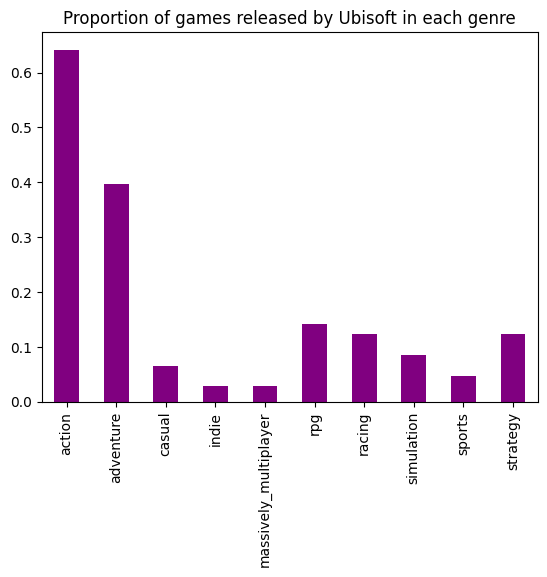

In [36]:
df[df.Publisher == 'Ubisoft'][gen_cols].mean().plot.bar(color='purple')
plt.title('Proportion of games released by Ubisoft in each genre')

In [37]:
for publisher in pv_top_ten_pubs.index:
    most_common_genre = df[df.Publisher == publisher][gen_cols].mean().idxmax()
    print(f'{publisher} usually release {most_common_genre} games.')

SEGA usually release action games.
Ubisoft usually release action games.
Square Enix usually release rpg games.
Devolver Digital usually release indie games.
Electronic Arts usually release action games.
THQ Nordic usually release action games.
Valve usually release action games.
Xbox Game Studios usually release action games.
BANDAI NAMCO Entertainment usually release action games.
Bethesda Softworks usually release action games.


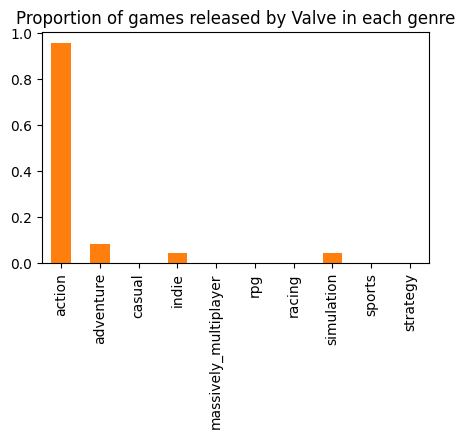

In [38]:
df[df.Publisher == 'Valve'][gen_cols].mean().plot.bar(figsize=(5,3), color='tab:orange')
plt.title('Proportion of games released by Valve in each genre');

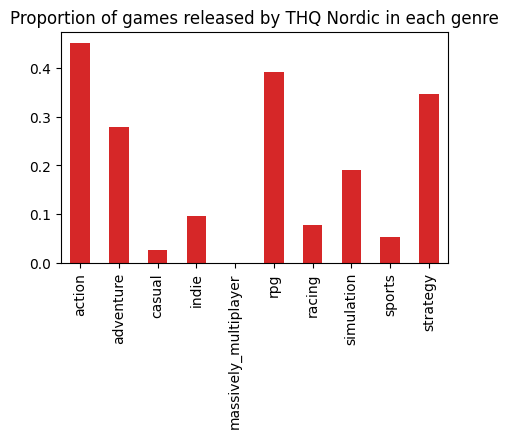

In [39]:
df[df.Publisher == 'THQ Nordic'][gen_cols].mean().plot.bar(figsize=(5,3), color='tab:red')
plt.title('Proportion of games released by THQ Nordic in each genre');

In [40]:
for Publisher in pv_top_ten_pubs.index:
    gen_values = df[df.Publisher == Publisher][gen_cols].mean().sort_values(ascending=False)
    
    total = gen_values.sum()
    proportions = [val / total for val in gen_values]
    
    gen_proportions = pd.DataFrame(zip(gen_values, proportions), index=gen_values.index, columns=['mean', 'proportion'])
    
    total_proportion = 0
    i = 0
    genres = []
    
    while total_proportion < .5:
        row_prop = gen_proportions.iloc[i, 1]
        genres.append(gen_proportions.index[i])
        total_proportion += row_prop
        i += 1
    
    print(f'{Publisher} tend to release {"/".join(genres)} games.')

SEGA tend to release action/adventure games.
Ubisoft tend to release action/adventure games.
Square Enix tend to release rpg/action games.
Devolver Digital tend to release indie/action games.
Electronic Arts tend to release action/adventure games.
THQ Nordic tend to release action/rpg/strategy games.
Valve tend to release action games.
Xbox Game Studios tend to release action/adventure games.
BANDAI NAMCO Entertainment tend to release action/rpg games.
Bethesda Softworks tend to release action games.


## Correlations

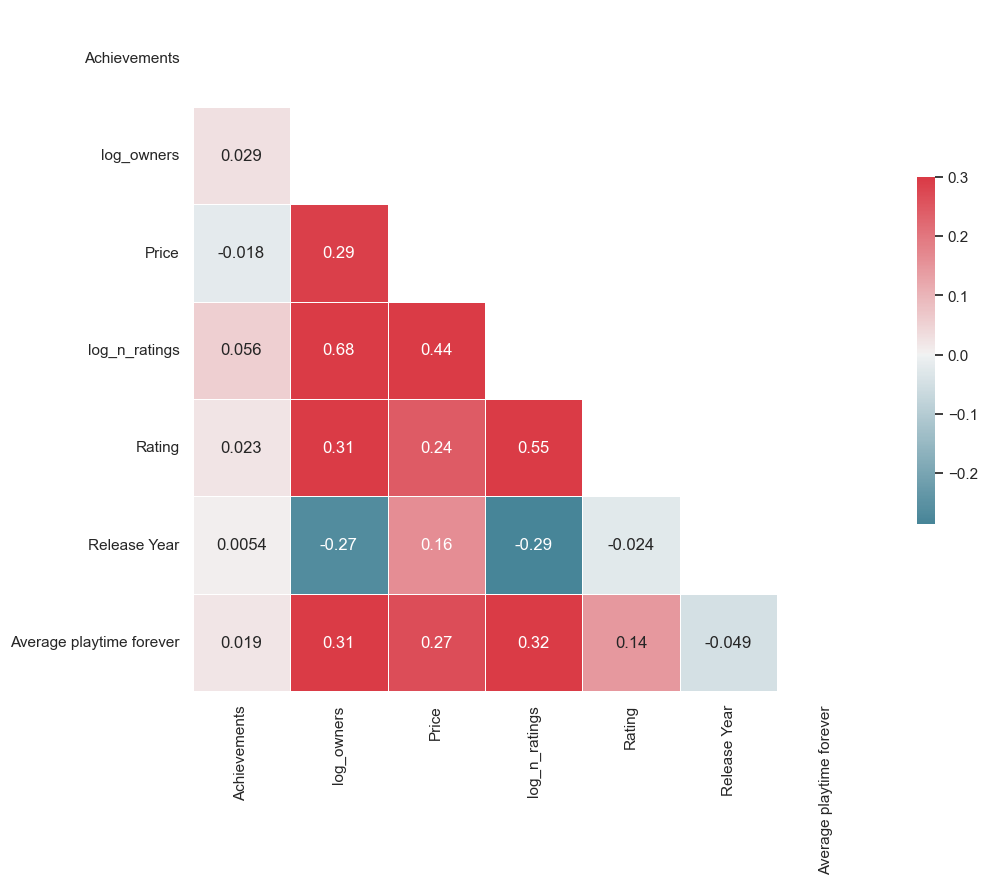

In [41]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style='white')
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    
    plt.yticks(rotation=0)
    plt.show()
    plt.rcdefaults()

corr_df = df.copy()
corr_df['log_owners'] = np.log10(corr_df['Estimated owners'])
corr_df['log_n_ratings'] = np.log10(corr_df['Total Ratings'])

plot_correlation_heatmap(corr_df[['Achievements', 'log_owners', 'Price', 'log_n_ratings', 'Rating', 'Release Year', 'Average playtime forever']])

We noticed some of these trends already, including the relationship between the number of owners and the number of ratings, between price and number of ratings, and between the release year and the number of owners.

We'll now plot a similar heatmap just for the category and genre columns.

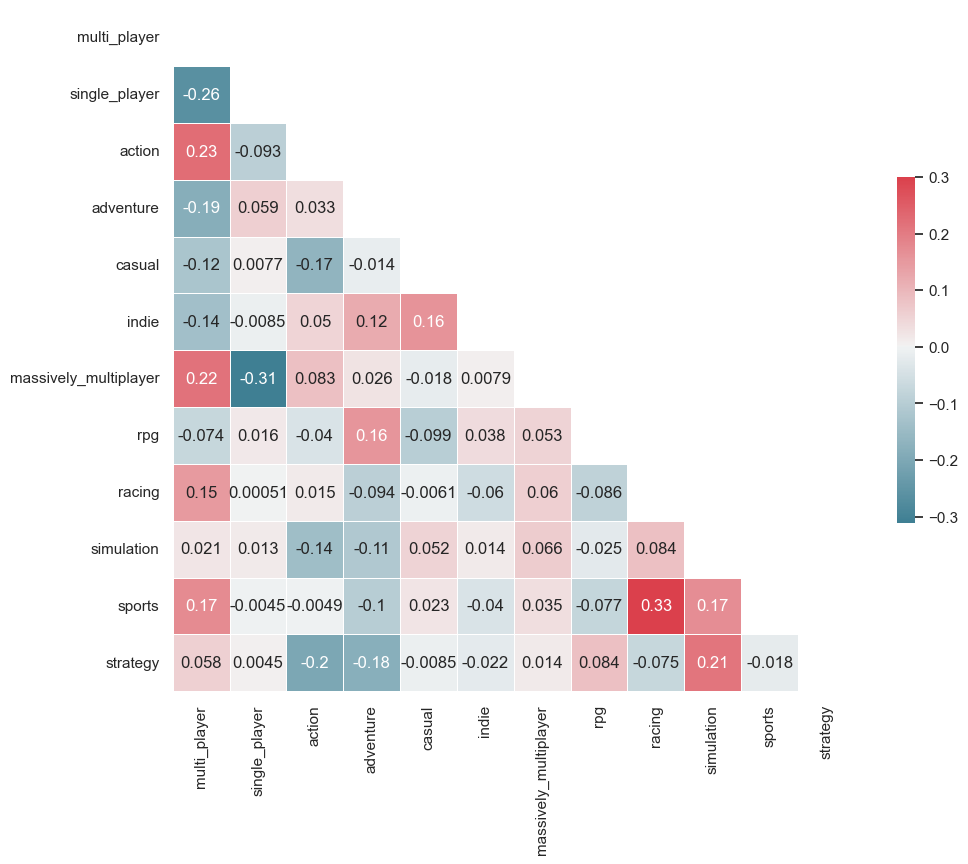

In [42]:
plot_correlation_heatmap(corr_df[cat_gen_cols])